# Group Homework 1
## Group 4
## Python k-nn Classification of Red Wine
## 1 February 2017

# 1. Load the data file and libraries

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn import neighbors, linear_model
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import classification_report
%matplotlib inline

red_wine = pd.read_csv("winequality-red.csv", sep=';')

# 2. Construct a new binary column indicating whether the wine is good or not

We define a good wine as having a quality of 6 or higher. We set 1 to be "good wine" and 0 to be "bad wine".

In [12]:
good_wine = red_wine['quality'].values >= 6
good_wine = good_wine*1

# 3. Normalize the data

An issue with this dataset is the different scales used to measure the input variables. For example, chlorides range between 0.012 and 0.6 and total sulfur dioxide ranges between 6 and 289. As a result, we need to scale and standardize the input data. We do not normalize the good_wine column because it is a categorical binary variable.

We plot the histograms of all the columns in our data set to highlight this issue.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109c05cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10a291cf8>]], dtype=object)

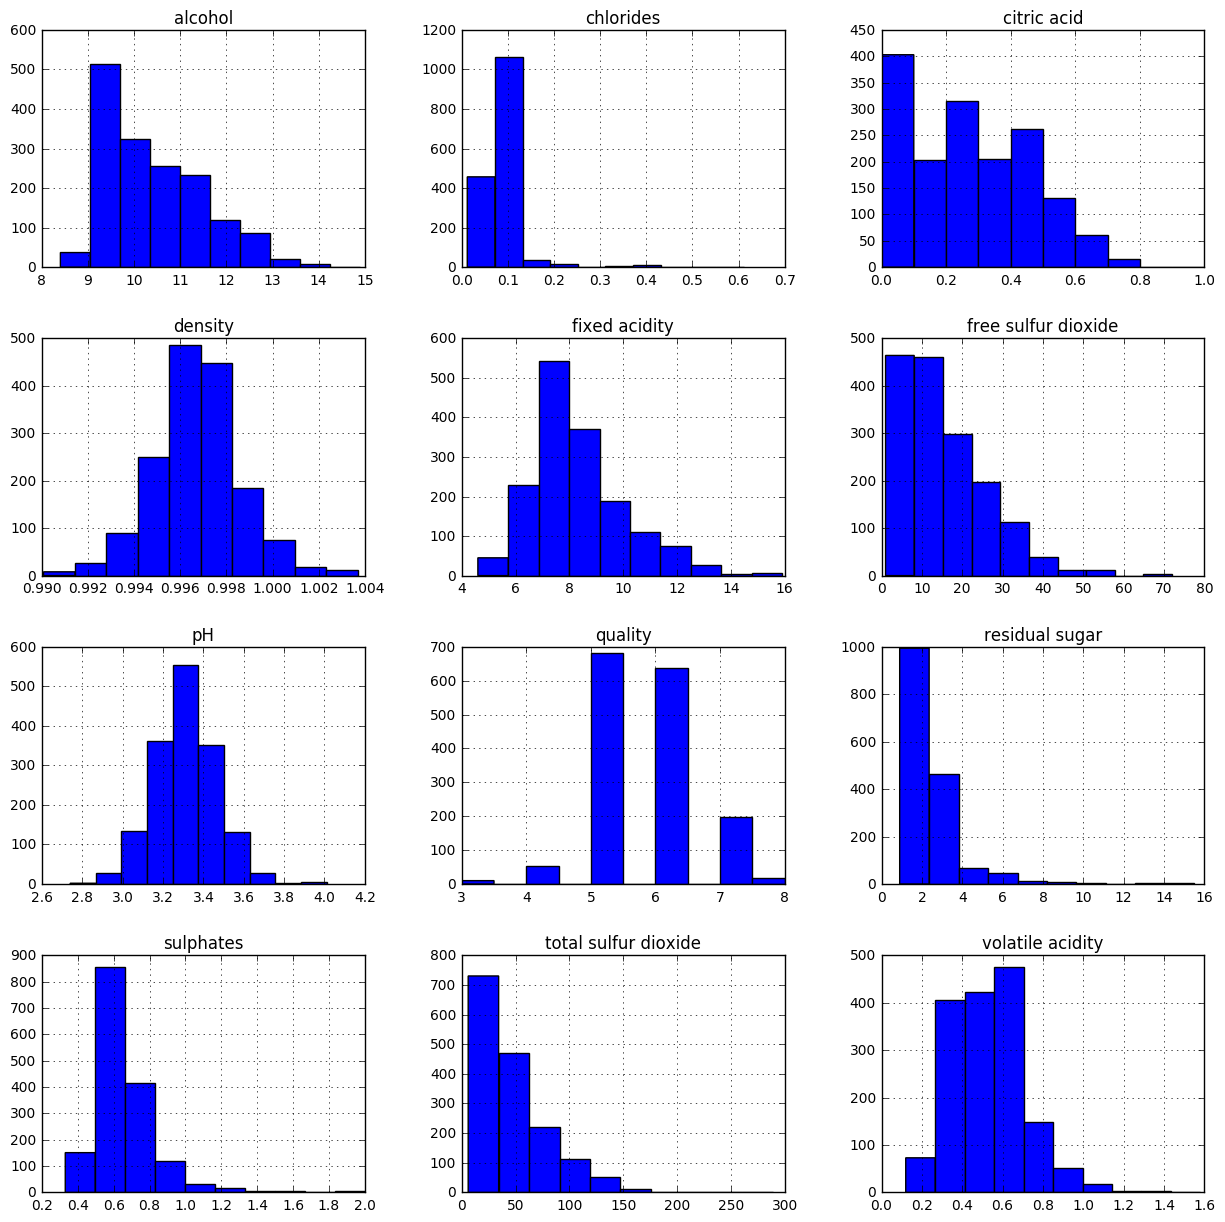

In [13]:
pd.DataFrame.hist(red_wine, figsize=[15,15])

We split our dataset into the input predictors and the outcome categorical variables. We then compute a z-score for all of the input variables.

In [14]:
input_cols = list(red_wine.ix[:, red_wine.columns != 'quality'].columns)

In [15]:
red_transform = pd.DataFrame()
for col in input_cols:
    red_transform[col + '_zscore'] = (red_wine[col] - red_wine[col].mean()) / red_wine[col].std()

predictors_z = red_transform.values

The data is now normalized with each attribute having mean = 0 and standard deviation = 1.

# 4. Split the data into random training and test subsets

In [16]:
Z_train, Z_test, y_train, y_test = train_test_split(predictors_z, good_wine,
                                                    test_size=0.5,
                                                    random_state=42)

# 5. Train the k-Nearest Neighbours classifiers

In [17]:
train_scores= {}
for i in np.arange(1, 500, 5):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(Z_train, y_train)
    s = knn.score(Z_train, y_train)
    train_scores[i]  = 1 - s.mean()

# 6. Evaluate each classifier using 5-fold cross validation

We will get 5 folds, each with 640 data points used for training the algorithm and 160 data points used for validation.

For each k, we find the average accuracy of all the folds and then we choose the k with the highest accuracy on the validation set.

In [27]:
scores_dict = dict()
for i in np.arange(1, 500, 5):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, Z_train, y_train, cv=5, scoring='accuracy')
    scores_dict[i] = 1- scores.mean()

## Optimal k and cross-validated accuracy

In [41]:
k_optimal = min(scores_dict, key=scores_dict.get)
k_optimal_score = 100 - round(100* scores_dict[min(scores_dict, key=scores_dict.get)],3)

print("The best predictor occurs when k =", k_optimal, "with a prediction accuracy of", k_optimal_score,"%. This is equivalent to an error rate of ", 100 - k_optimal_score, "%.")

The best predictor occurs when k = 86 with a prediction accuracy of 75.244 %. This is equivalent to an error rate of  24.756 %.


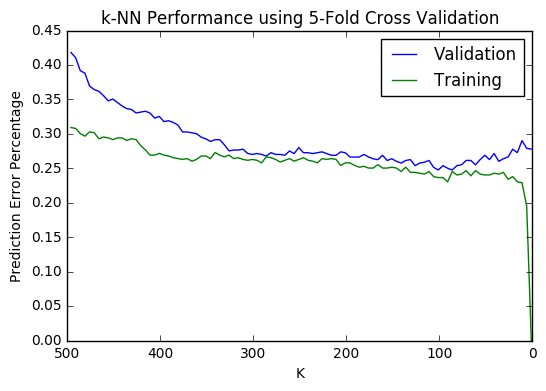

In [30]:
plt.plot(*zip(*sorted(scores_dict.items())), label = "Validation")
plt.plot(*zip(*sorted(train_scores.items())), label = "Training")

plt.xlabel("K")
plt.ylabel("Prediction Error Percentage")
plt.title("k-NN Performance using 5-Fold Cross Validation")
plt.legend()
plt.gca().invert_xaxis()

# 7. Predict the generalisation error using the test data set

In [35]:
knn = neighbors.KNeighborsClassifier(n_neighbors=max(scores_dict, key=scores_dict.get))
model = knn.fit(Z_train, y_train)
y_true, y_pred = y_test, model.predict(Z_test)
gen_error = 100*(1 - model.score(Z_test, y_test))
prediction_accuracy = 100 - gen_error

In [36]:
print("The generalization error on the test data set when using the optimal predictor k = ", k_optimal, "on the new test dataset is", gen_error, "%. This is equivalent to a prediction accuracy of ", prediction_accuracy, "%.")

The generalization error on the test data set when using the optimal predictor k =  86 on the new test dataset is 34.25 %. This is equivalent to a prediction accuracy of  65.75 %.


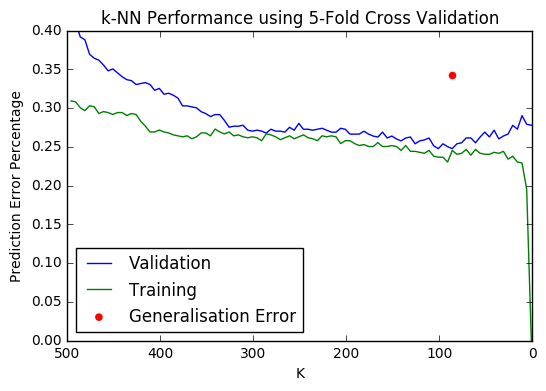

In [39]:
plt.plot(*zip(*sorted(scores_dict.items())), label = "Validation")
plt.plot(*zip(*sorted(train_scores.items())), label = "Training")
plt.scatter(k_optimal, gen_error/100, color = 'r', label = "Generalisation Error")
plt.ylim([0,0.4])
plt.xlim([0,500])
plt.xlabel("K")
plt.ylabel("Prediction Error Percentage")
plt.title("k-NN Performance using 5-Fold Cross Validation")
plt.legend(loc = "lower left", scatterpoints = 1)
plt.gca().invert_xaxis()

## Confusion Matrix

In [40]:
conf1 = sum((y_pred == 1) & (y_true == 1))
conf2 = sum((y_pred == 0) & (y_true == 1))
conf3 = sum((y_pred == 1) & (y_true == 0))
conf4 = sum((y_pred == 0) & (y_true == 0))
    
conf = pd.DataFrame([[conf1,conf2],[conf3,conf4]])
conf.columns = ['Good','Bad']
conf.rename({0:'Good',1:'Bad'}, inplace = True)

print(conf)

      Good  Bad
Good   361   53
Bad    221  165


# Suitability of classifier

As shown above, with this particular random training/test data split, we achieve an error rate of about 25%. This is not a particularly good estimate but is the best $k$ that we found. Similar to the previous classifer on the white wines, we realise that the variance in optimal $k$ is very high, and it varies heavily with the randomised training/test split.

If we look at the confusion matrix, the classifer does a relatively good job predicting good wines, however, when it comes to bad wines, the classifer only manages to correctly classify roughly 42% of the wines. Similarly, we are more inclined to filter out bad wines and would prefer to err on the side of caution. Instead of using a binary classifier, we could give probabilities equal to the proportion of nearest neighbours in each class. For example, for $k=100$, if a point has 70 "good" neighbours and 30 "bad" neighbours, then we would assign the point to the class "good" with probability 0.7. In the binary case, we would assign the point to the class with probability greater or equal to 0.5, however, if if we assign probabilities instead, we can be more conservative, and only assign a wine to the "good" class if it has a probability of being "good" at say 0.6 or higher.

When finding the optimum $k$, we could also assign costs to misclassification, where we want to minimise the total cost of misclassification. In this classifier, we assigned equal weights to the case "assigned good wine to bad class" and "assigned bad wine to good class". Similar to the probability alternative above, we could assign a higher penalty to the case "assigned bad wine to good class" and instead of minimising error, we find the $k$ that minimises the cost of misclassification.